## CORE

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
import matplotlib.pyplot as plt

Image Size: (10240, 8192, 3)


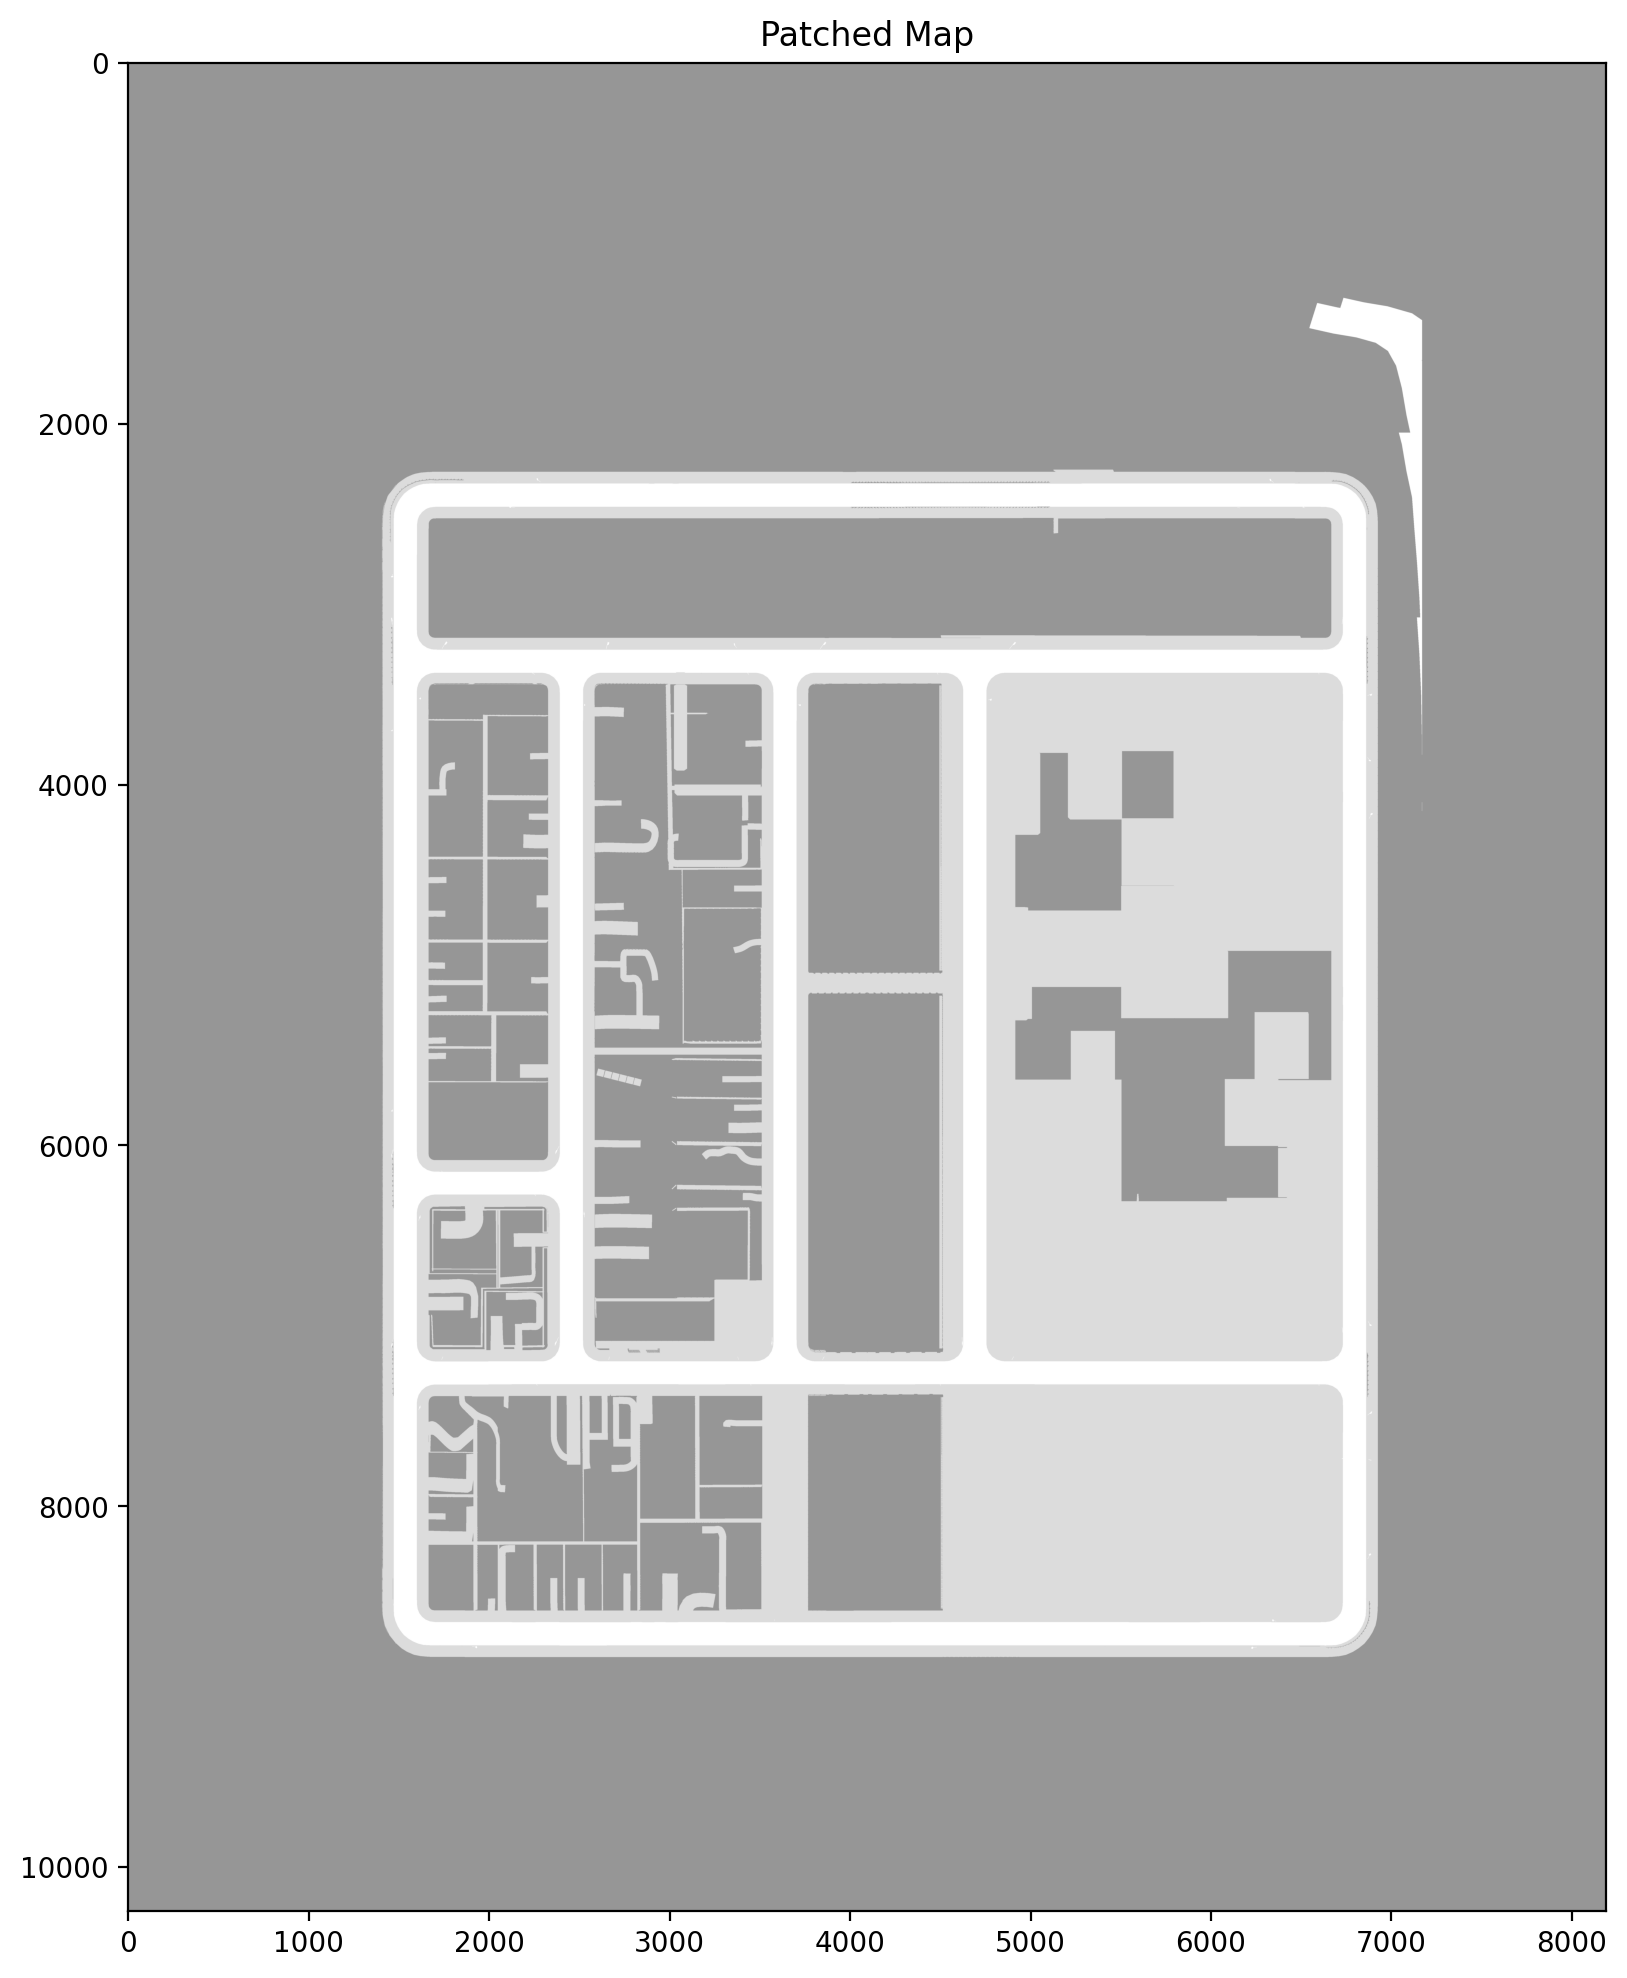

In [3]:
from CarlaBEV.envs.utils import load_map

rgbmap, _, _ = load_map(size=1024)

print(f"Image Size: {rgbmap.shape}")

# Example: Patch a white rectangle at (y0, x0) with height h and width w

# If rgbmap is float [0,1], use 1.0; if uint8 [0,255], use 255
if rgbmap.dtype == np.uint8:
    white = 255
else:
    white = 1.0

y0, x0 = 7409, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3466, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 7256, 3492    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3406, 4689    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

plt.imshow(rgbmap)
plt.title("Patched Map")
plt.show()

In [4]:
intersections = [
    (8642, 1564),
    (8654, 6755),
    (7250, 1552),
    (7241, 2446),
    (7242, 3652),
    (7242, 4704),
    (7257, 6773),
    (6199, 1552),
    (6197, 2439),
    (3349, 1545),
    (3350, 2456),
    (3350, 3639),
    (3335, 4714),
    (3315, 6773),
    (2456, 1563),
    (2446, 6757),
 ]

intersections = [(y, x) for x, y in intersections]

map_edges = {}
for i, coord in enumerate(intersections):
    x, y = coord
    map_edges[i] = (x, y)
    print(i, map_edges[i])

0 (1564, 8642)
1 (6755, 8654)
2 (1552, 7250)
3 (2446, 7241)
4 (3652, 7242)
5 (4704, 7242)
6 (6773, 7257)
7 (1552, 6199)
8 (2439, 6197)
9 (1545, 3349)
10 (2456, 3350)
11 (3639, 3350)
12 (4714, 3335)
13 (6773, 3315)
14 (1563, 2456)
15 (6757, 2446)


## GET CENTERLINE   

In [5]:
from skimage.color import rgb2gray
from skimage.morphology import skeletonize

def get_midlane_coords(rgbmap):
    gray = rgb2gray(rgbmap)
    binary = gray > 0.99  # Adjust threshold if needed
    # Skeletonize to get lane centerlines
    skeleton = skeletonize(binary)
    # Get coordinates of skeleton pixels (centerline points)
    centerline_coords = np.argwhere(skeleton)
    return centerline_coords

Direct intersection pairs (by index): [(0, 1), (0, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 11), (5, 6), (5, 12), (6, 13), (7, 8), (7, 9), (8, 10), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13), (13, 15), (14, 15)]


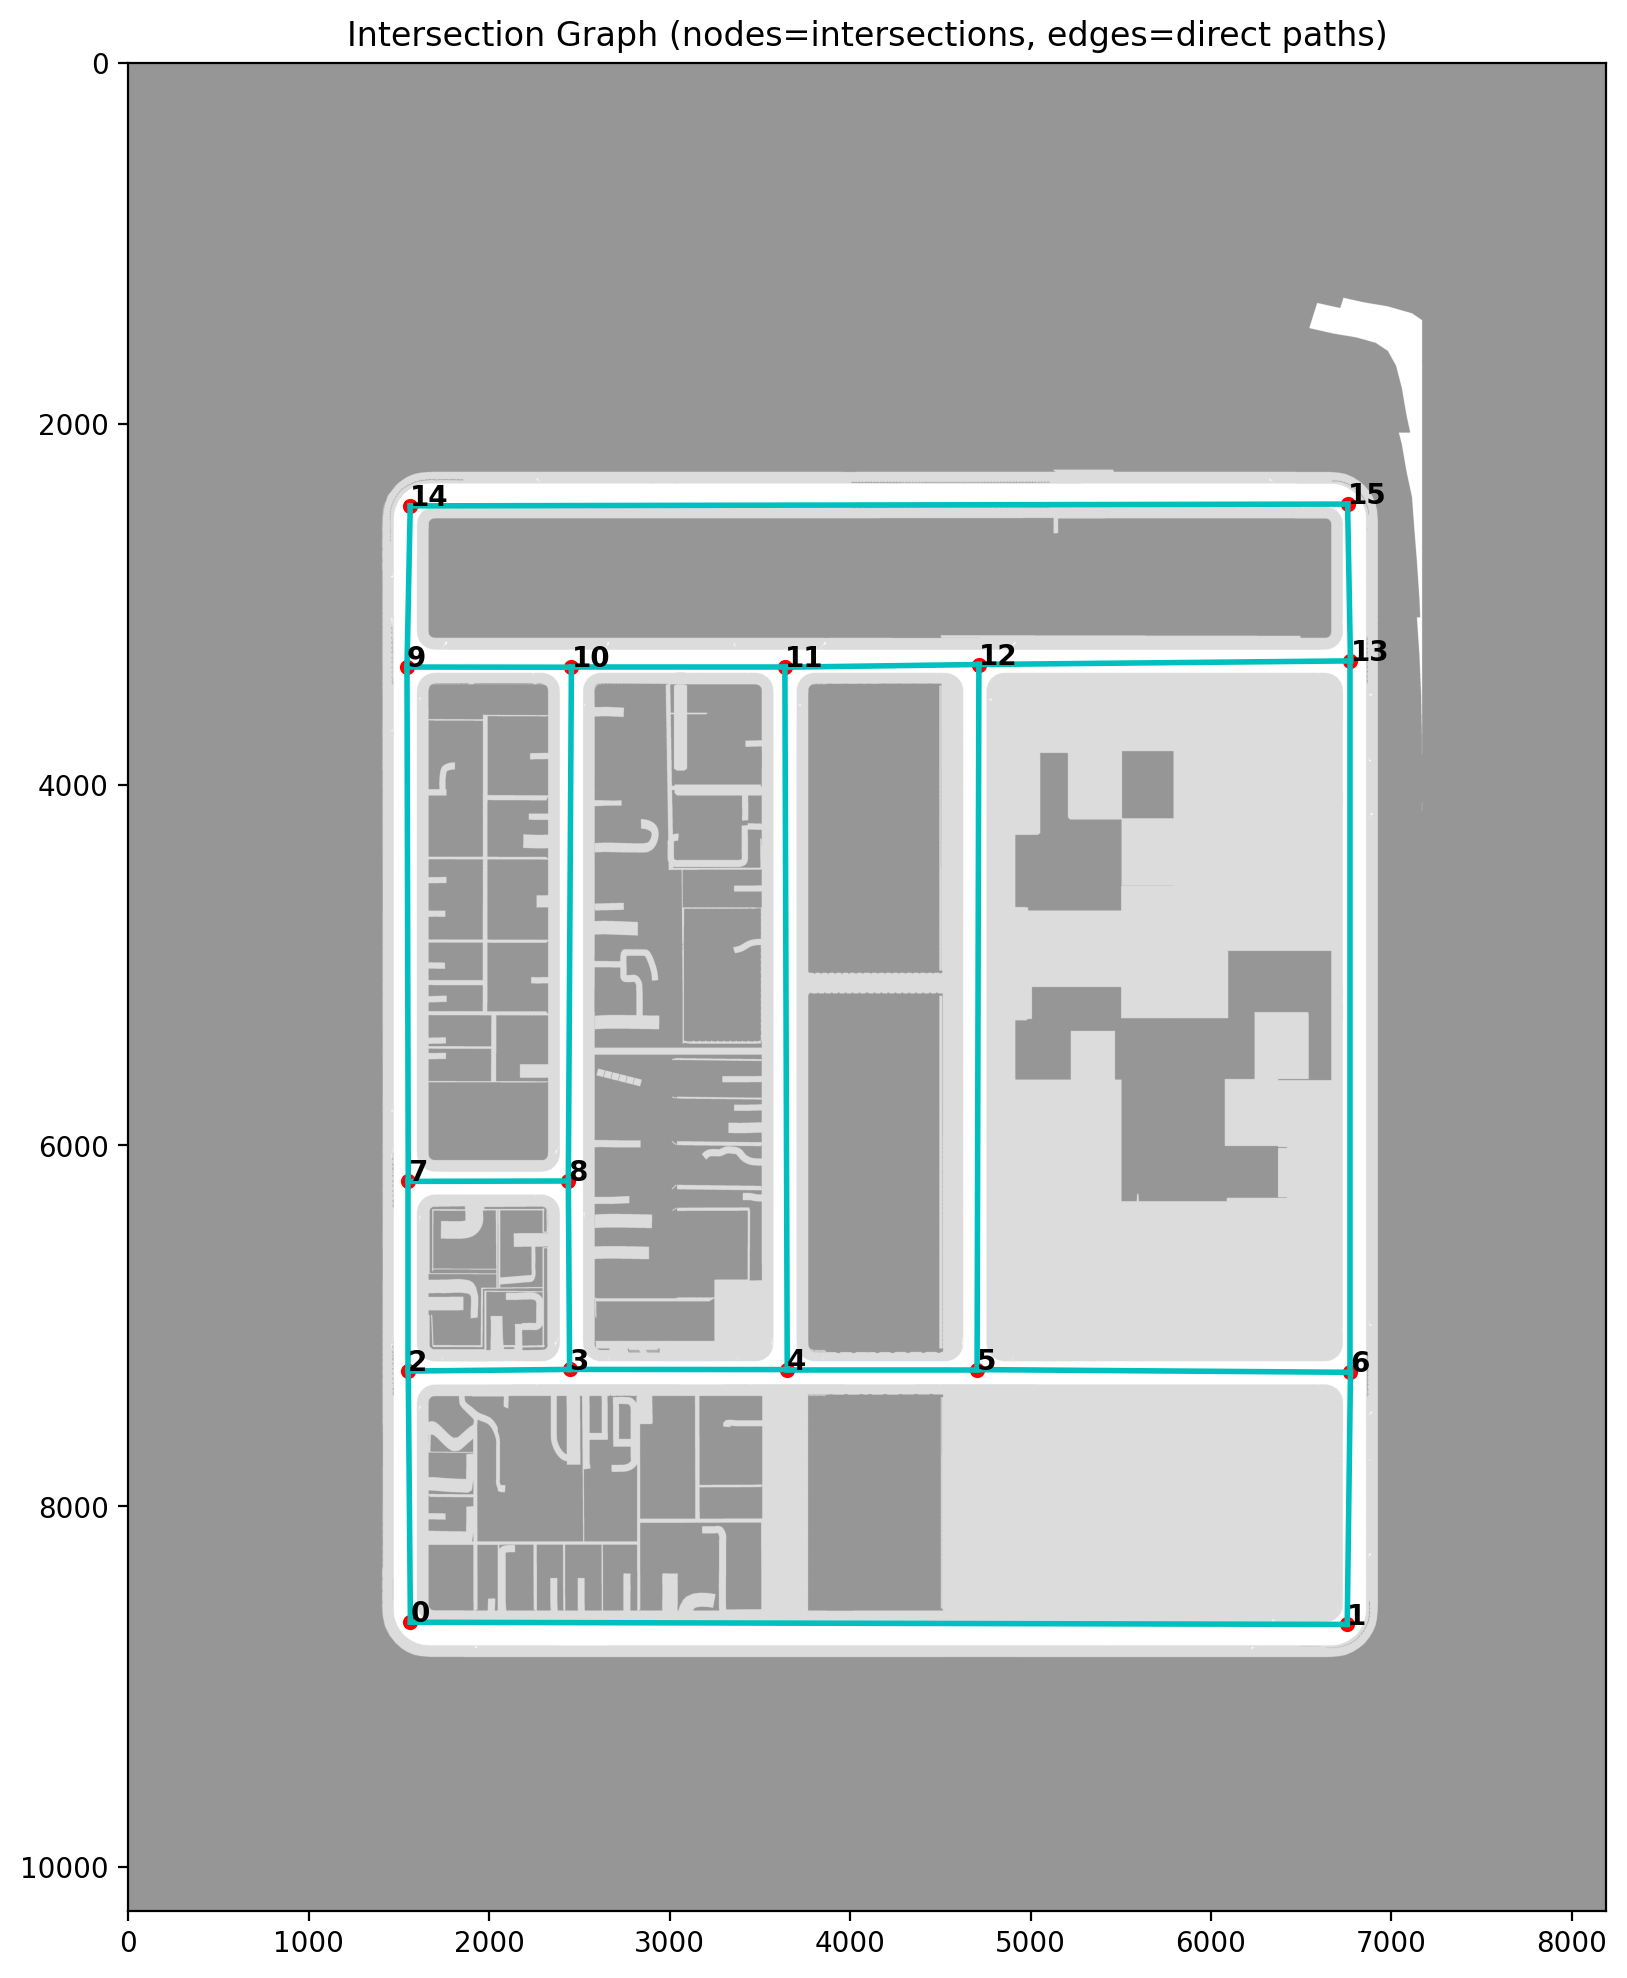

In [6]:
centerline_coords = get_midlane_coords(rgbmap)
centerline_coords = centerline_coords[:, [1, 0]]

# 1. Find the closest centerline point for each intersection
intersection_nodes = []
for intersection in intersections:
    dists = np.linalg.norm(centerline_coords - intersection, axis=1)
    idx_min = np.argmin(dists)
    intersection_nodes.append(tuple(centerline_coords[idx_min]))


# 2. Build a pixel adjacency graph for centerline_coords (for pathfinding only)
pixel_graph = nx.Graph()
centerline_set = set(map(tuple, centerline_coords))
for y, x in centerline_coords:
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = (y + dy, x + dx)
            if neighbor in centerline_set:
                pixel_graph.add_edge((y, x), neighbor)

# 3. Precompute a set of "blocked" pixels for each intersection (within a radius)
block_radius = 50  # pixels
blocked_pixels = []
for node in intersection_nodes:
    y0, x0 = node
    pixels = set()
    for dy in range(-block_radius, block_radius+1):
        for dx in range(-block_radius, block_radius+1):
            if dy**2 + dx**2 <= block_radius**2:
                pixels.add((y0+dy, x0+dx))
    blocked_pixels.append(pixels)

# 4. Build the intersection graph
G_intersections = nx.Graph()
for idx in range(len(intersections)):
    G_intersections.add_node(idx, pos=intersections[idx])

for i, node_a in enumerate(intersection_nodes):
    for j, node_b in enumerate(intersection_nodes):
        if i < j:
            try:
                path = nx.shortest_path(pixel_graph, node_a, node_b)
                path_set = set(path[1:-1])
                blocked = False
                for k, block in enumerate(blocked_pixels):
                    if k != i and k != j and path_set & block:
                        blocked = True
                        break
                if not blocked:
                    G_intersections.add_edge(i, j)
            except nx.NetworkXNoPath:
                continue

print("Direct intersection pairs (by index):", list(G_intersections.edges))

# Visualization
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
for i, j in G_intersections.edges:
    a = intersections[i]
    b = intersections[j]
    plt.plot([a[0], b[0]], [a[1], b[1]], 'c-', lw=2)
plt.title("Intersection Graph (nodes=intersections, edges=direct paths)")
plt.show()

## Get Lanes

In [7]:
def sample_equidistant_points(path_coords, step=100):
    """Given a list of (y, x) coords, return equidistant points along the path."""
    path_coords = np.array(path_coords)
    # Compute cumulative distance along the path
    deltas = np.diff(path_coords, axis=0)
    dists = np.sqrt((deltas**2).sum(axis=1))
    cumdist = np.insert(np.cumsum(dists), 0, 0)
    total_dist = cumdist[-1]
    n_points = int(total_dist // step)
    if n_points < 2:
        return path_coords  # Path too short, return as is
    sample_dists = np.linspace(0, total_dist, n_points)
    sampled_points = np.empty((n_points, 2))
    sampled_points[0] = path_coords[0]
    sampled_points[-1] = path_coords[-1]
    j = 1
    for i in range(1, n_points-1):
        d = sample_dists[i]
        while cumdist[j] < d:
            j += 1
        ratio = (d - cumdist[j-1]) / (cumdist[j] - cumdist[j-1])
        sampled_points[i] = path_coords[j-1] + ratio * (path_coords[j] - path_coords[j-1])
    return sampled_points.astype(int)


In [8]:
def compute_lane_offsets(waypoints, lane_width=6.0):
    """
    Given centerline waypoints (N,2), return left and right lane waypoints.
    lane_width: total width of both lanes (in pixels, adjust as needed)
    """
    waypoints = np.array(waypoints)
    left_lane = []
    right_lane = []
    side_1, side_2 = [], []
    offset = lane_width / 2.0
    offset_ped = lane_width + 10

    for i in range(len(waypoints)):
        # Compute direction vector
        if i == 0:
            direction = waypoints[i+1] - waypoints[i]
        elif i == len(waypoints) - 1:
            direction = waypoints[i] - waypoints[i-1]
        else:
            direction = waypoints[i+1] - waypoints[i-1]
        direction = direction / np.linalg.norm(direction)
        # Normal vector (perpendicular, 2D)
        normal = np.array([-direction[1], direction[0]])
        # Offset points
        left_lane.append(waypoints[i] + offset * normal)
        right_lane.append(waypoints[i] - offset * normal)
        side_1.append(waypoints[i] + offset_ped * normal)
        side_2.append(waypoints[i] - offset_ped * normal)
    return np.array(left_lane), np.array(right_lane), np.array(side_1), np.array(side_2)


In [9]:
# Usage
lane_width_pixels = 80  # Adjust to your map's scale

segment_info = {}
wrong_lanes = ["0->2", "2->3", "3->4", "4->5", "5->6", "2->7",
         "7->8", "7->9", "9->10", "10->11", "11->12", "12->13", "9->14", "14->15"]

for i, j in list(G_intersections.edges):
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
    # Get the pixel path between intersections
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    # Sample equidistant points (e.g., every n pixels)
    waypoints = sample_equidistant_points(path, step=100)

    right_lane, left_lane, _, _ = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)
    direction = "j->i" if f"{i}->{j}" in wrong_lanes else "i->j"
    # Store metadata
    segment_info[(i, j)] = {
        "centerline": waypoints,
        "L": left_lane,
        "R": right_lane,
        "direction": direction,  # default
    }
    if direction == "j->i":
        segment_info[(i, j)]["L"], segment_info[(i, j)]["R"] = right_lane, left_lane
    
    print((i, j), direction)

(0, 1) i->j
(0, 2) j->i
(1, 6) i->j
(2, 3) j->i
(2, 7) j->i
(3, 4) j->i
(3, 8) i->j
(4, 5) j->i
(4, 11) i->j
(5, 6) j->i
(5, 12) i->j
(6, 13) i->j
(7, 8) j->i
(7, 9) j->i
(8, 10) i->j
(9, 10) j->i
(9, 14) j->i
(10, 11) j->i
(11, 12) j->i
(12, 13) j->i
(13, 15) i->j
(14, 15) j->i


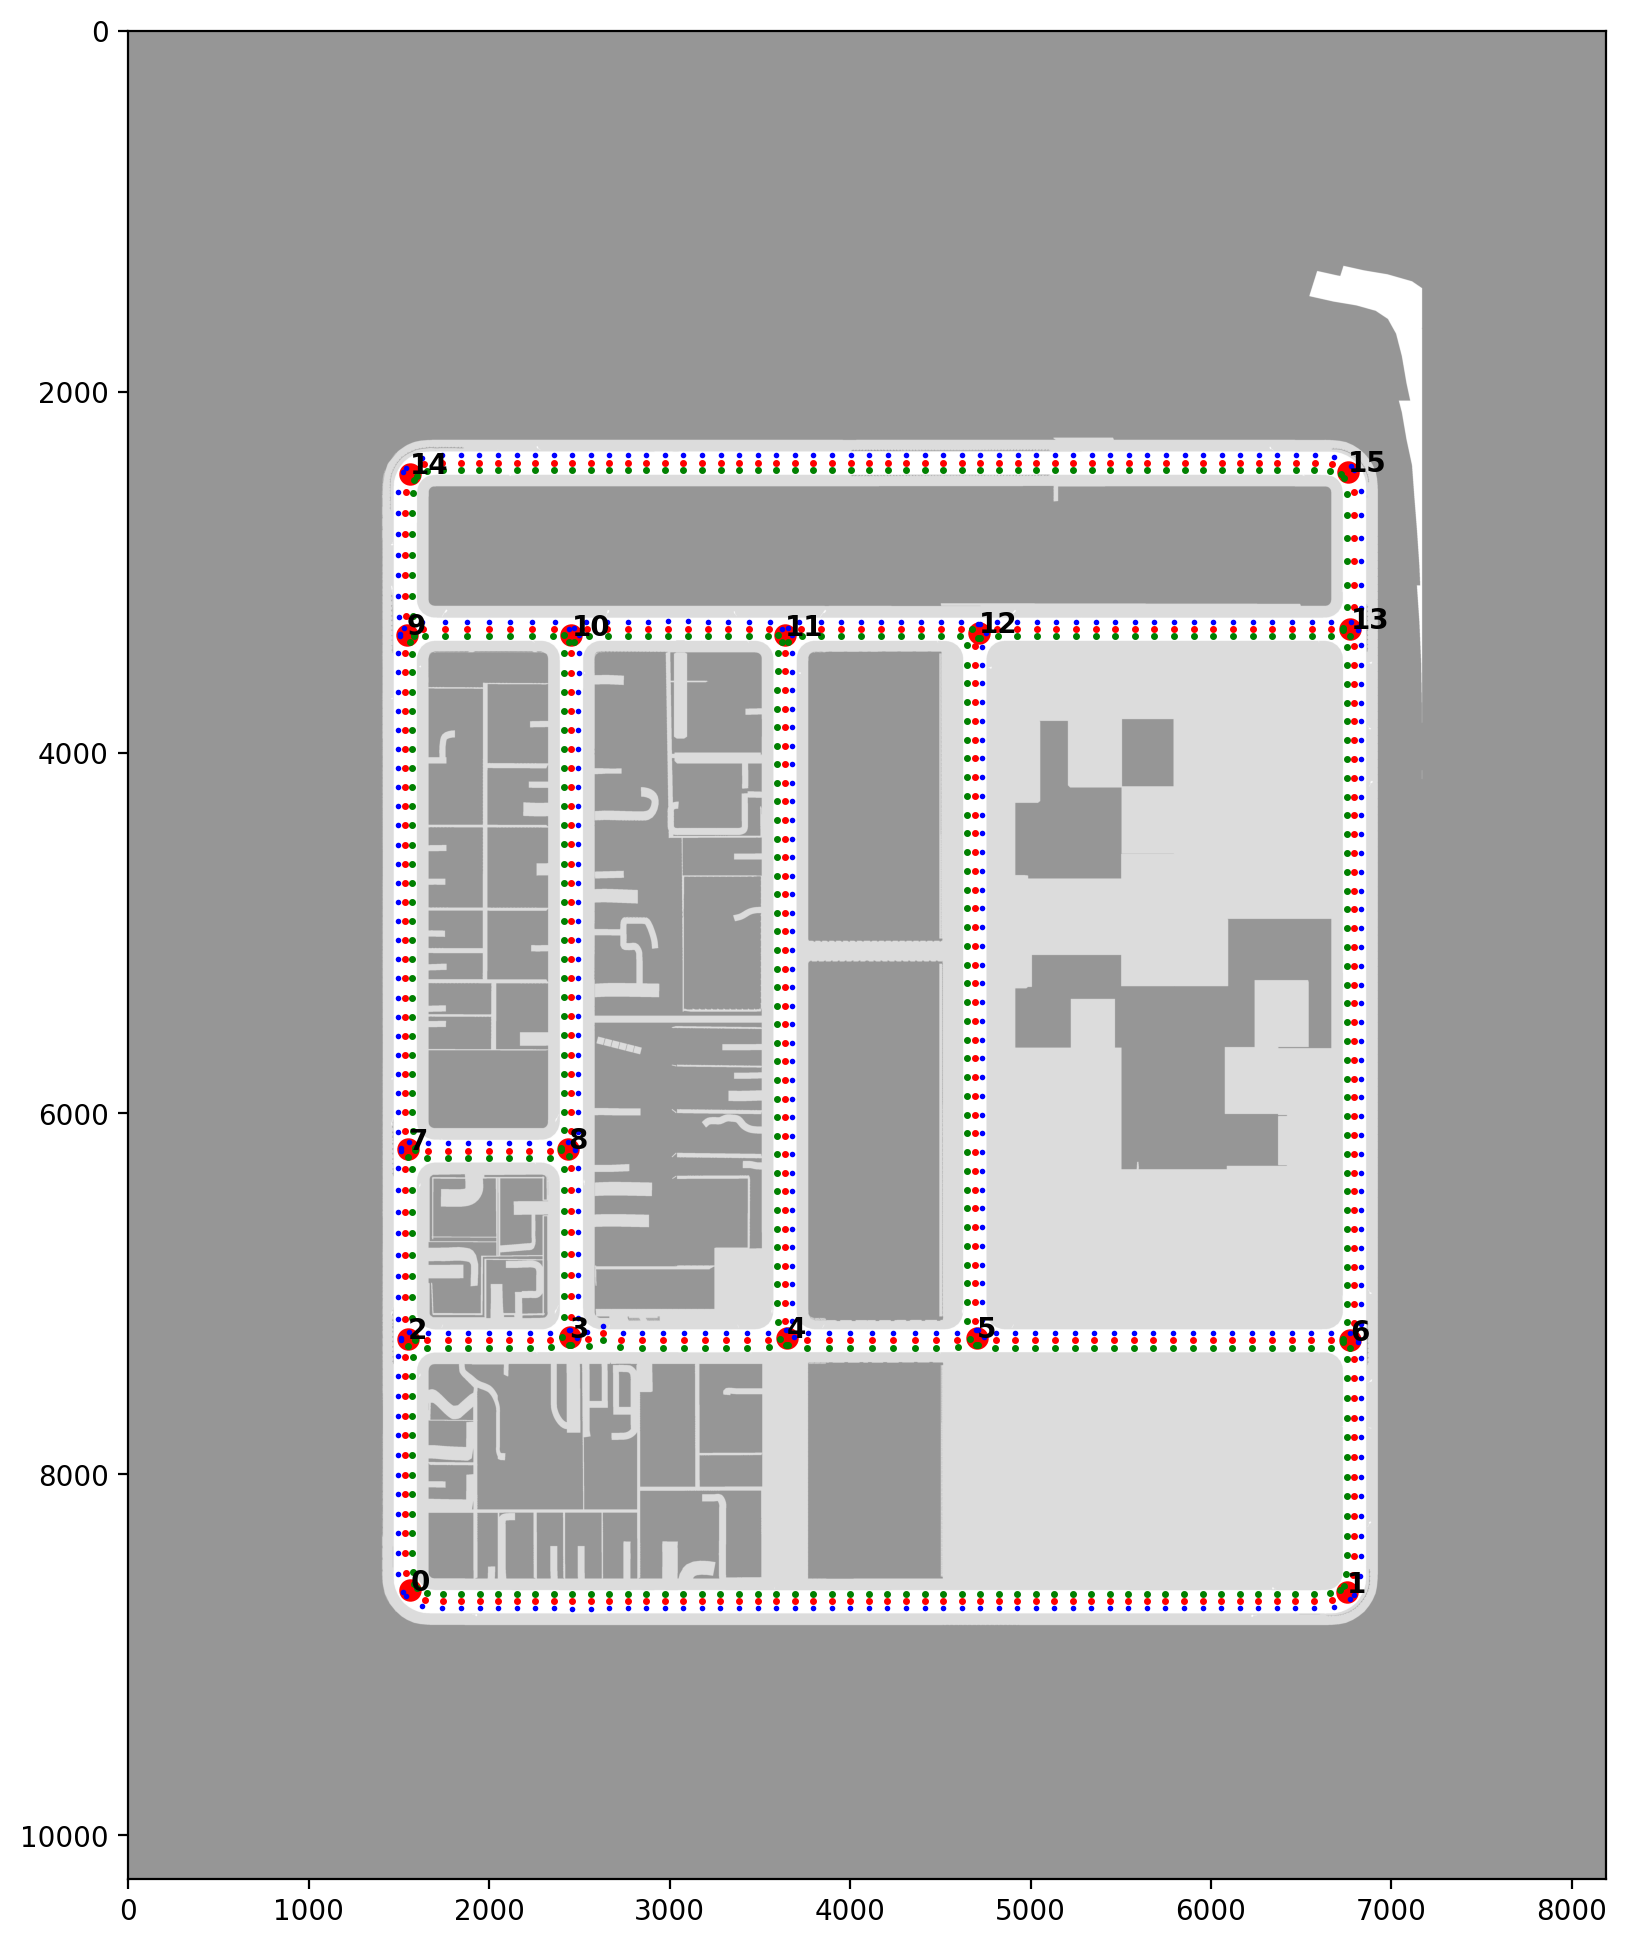

In [10]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for segment in segment_info.keys():
    waypoints = segment_info[segment]["centerline"]
    left = segment_info[segment]["L"]
    right = segment_info[segment]["R"]
    plt.plot(left[:,0], left[:,1], 'g.', markersize=3)
    plt.plot(waypoints[:,0], waypoints[:,1], 'r.', markersize=3)
    plt.plot(right[:,0], right[:,1], 'b.', markersize=2)

for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')

In [11]:
connections = [
    ((0, 1), (1, 6)), ((0, 1), (0, 2)),
    ((0, 2), (2, 3)), ((0, 2), (2, 7)),
    ((2, 3), (2, 7)), ((2, 3), (3, 4)), ((2, 3), (3, 8)),
    ((3, 4), (3, 8)), ((3, 4), (4, 5)), ((3, 4), (4, 11)),
    ((4, 5), (5, 6)), ((4, 5), (4, 11)), ((4, 5), (5, 12)),
    ((1, 6), (5, 6)), ((1, 6), (6, 13)), ((5, 6), (5, 12)),
    ((2, 7), (7, 8)), ((2, 7), (7, 9)), ((6, 13), (5, 6)),
    ((3, 8), (8, 10)), ((3, 8), (7, 8)), ((7, 8), (8, 10)),
    ((4, 11), (10, 11)), ((4, 11), (11, 12)), ((7, 9), (7, 8)),
    ((5, 12), (11, 12)), ((5, 12), (12, 13)),
    ((6, 13), (13, 15)), ((8, 10), (10, 11)),
    ((7, 9), (9, 10)), ((7, 9), (9, 14)), ((9, 14), (9, 10)),
    ((8, 10), (9, 10)), ((9, 10), (10, 11)),
    ((10, 11), (11, 12)), ((11, 12), (12, 13)),
    ((12, 13), (13, 15)), ((9, 14), (14, 15)), ((12, 13),(6, 13)),
    ((14, 15), (13, 15))
]


## HELPER FUNCTIONS

In [12]:
def get_route_waypoints(pixel_graph, node_a, node_b ):
    # 2. For each consecutive pair, find pixel path and discretize
    pixel_path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(pixel_path, step=300)  # step in pixels
    return waypoints

In [41]:
def add_lane_segment(G, seg_id, lane_points, lane_type, step_cost=1.0, conn_cost=0.3):
    """
    Adds waypoints for a segment lane and connects them.
    Right lane: from a → b (unless direction is flipped)
    Left lane: from b → a (unless direction is flipped)
    """
    a, b = seg_id
    if len(lane_points) < 2:
        return G

    lane_label = "R" if lane_type == "R" else "L"

    # Define order: right → forward, left → reversed
    if lane_type == "R":
        ordered_points = lane_points
        start_inter, end_inter = f"intersection_{a}", f"intersection_{b}"
    else:  # left lane flows backward
        ordered_points = list(reversed(lane_points))
        start_inter, end_inter = f"intersection_{b}", f"intersection_{a}"

    # Create intersection nodes (ensure position consistency)
    G.add_node(start_inter, pos=ordered_points[0], type="intersection")
    G.add_node(end_inter, pos=ordered_points[-1], type="intersection")

    # Create nodes for waypoints
    n_nodes = len(ordered_points)
    node_ids = []
    for i, pt in enumerate(ordered_points):
        node_id = f"{a}_{b}_{lane_label}_{i}"
        G.add_node(node_id, pos=pt, lane=lane_type, segment=(a, b))
        node_ids.append(node_id)

    # Connect internal waypoints
    for u, v in zip(node_ids[:-1], node_ids[1:]):
        G.add_edge(u, v, cost=step_cost, lane=lane_type)

    return G

In [42]:
def flip_road_directions(segment_info_copy, directions):
    # Flip segments in the dictionary
    for desired_direction, seg_list in directions.items():
        for seg_id in seg_list:
            if seg_id not in segment_info_copy:
                print(f"⚠️ Segment {seg_id} not found, skipping.")
                continue

            current_dir = segment_info_copy[seg_id].get("direction", "i->j")

            if current_dir != desired_direction:
                # Flip the direction metadata
                segment_info_copy[seg_id]["direction"] = desired_direction

                # Reverse the lane points
                for lane_key in ["R", "L", "right_lane", "left_lane"]:
                    if lane_key in segment_info_copy[seg_id]:
                        segment_info_copy[seg_id][lane_key] = list(
                            reversed(segment_info_copy[seg_id][lane_key])
                        )

                print(f"🔁 Flipped segment {seg_id} to {desired_direction}")
    return segment_info_copy

In [77]:
import numpy as np

def connect_neighbor_segments(G, segment_info, connections, lane_type="R"):
    """
    Connect neighboring segments by creating edges between their closest start/end points.
    
    Parameters
    ----------
    G : networkx.Graph
        Graph containing segment nodes.
    segment_info : dict
        Dictionary with segment data. Each segment has lane points under 'R'/'L'.
    connections : list of tuples
        List of neighboring segment pairs to connect, e.g., [(seg1, seg2), ...].
    lane_type : str
        'R' or 'L', indicating which lane to connect.
    """
    lane_label = lane_type.upper()

    for seg_a, seg_b in connections:
        points_a = np.array(segment_info[seg_a][lane_type])
        points_b = np.array(segment_info[seg_b][lane_type])

        if len(points_a) == 0 or len(points_b) == 0:
            continue

        # ⚙️ Reverse left-lane direction to match road flow
        if lane_label == "L":
            points_a = points_a[::-1]
            points_b = points_b[::-1]

        # Compute all pairwise distances
        dists = np.linalg.norm(points_a[:, None, :] - points_b[None, :, :], axis=2)
        idx_a, idx_b = np.unravel_index(np.argmin(dists), dists.shape)

        node_a = f"{seg_a[0]}_{seg_a[1]}_{lane_label}_{idx_a}"
        node_b = f"{seg_b[0]}_{seg_b[1]}_{lane_label}_{idx_b}"

        # Add bidirectional edges
        if idx_a > 2 and idx_b < 2:
            G.add_edge(node_a, node_b, cost=0.3, lane_type=lane_type)
        else:
            G.add_edge(node_b, node_a, cost=0.3, lane_type=lane_type)

        print(f"Connected {node_a} ↔ {node_b} (lane {lane_label})")

    return G


## Build Graph

In [78]:
# Deepcopy to avoid modifying original segment_info
segment_info_copy = deepcopy(segment_info)

In [79]:
# Deepcopy to avoid modifying original segment_info
map_data = deepcopy(segment_info_copy)

# Example correction list
directions = {
    "i->j": [],                # segments that should go from i to j
    "j->i": [(0, 1), (1, 6), (13, 15), (6 ,13)]  # segments that need to be flipped
}
map_data = flip_road_directions(map_data, directions)

# Initialize lane graphs
G_left = nx.DiGraph()
G_right = nx.DiGraph()

🔁 Flipped segment (0, 1) to j->i
🔁 Flipped segment (1, 6) to j->i
🔁 Flipped segment (13, 15) to j->i
🔁 Flipped segment (6, 13) to j->i


In [80]:
for seg_id, seg_data in map_data.items():
    seg_data["R"] =  seg_data["R"][1:-1]
    seg_data["L"] =  seg_data["L"][1:-1]
    add_lane_segment(G_right, seg_id, seg_data["R"], "R")
    add_lane_segment(G_left,  seg_id, seg_data["L"], "L")


# Try:
connect_neighbor_segments(G_left, connections=connections,lane_type="L", segment_info=map_data)
connect_neighbor_segments(G_right, connections=connections,lane_type="R", segment_info=map_data)

# Combined graph if needed
G_combined = nx.compose(G_left, G_right)

Connected 0_1_L_49 ↔ 1_6_L_0 (lane L)
Connected 0_1_L_0 ↔ 0_2_L_11 (lane L)
Connected 0_2_L_0 ↔ 2_3_L_6 (lane L)
Connected 0_2_L_0 ↔ 2_7_L_7 (lane L)
Connected 2_3_L_6 ↔ 2_7_L_7 (lane L)
Connected 2_3_L_0 ↔ 3_4_L_9 (lane L)
Connected 2_3_L_0 ↔ 3_8_L_7 (lane L)
Connected 3_4_L_9 ↔ 3_8_L_7 (lane L)
Connected 3_4_L_0 ↔ 4_5_L_7 (lane L)
Connected 3_4_L_0 ↔ 4_11_L_36 (lane L)
Connected 4_5_L_0 ↔ 5_6_L_17 (lane L)
Connected 4_5_L_7 ↔ 4_11_L_36 (lane L)
Connected 4_5_L_0 ↔ 5_12_L_36 (lane L)
Connected 1_6_L_11 ↔ 5_6_L_0 (lane L)
Connected 1_6_L_11 ↔ 6_13_L_0 (lane L)
Connected 5_6_L_17 ↔ 5_12_L_36 (lane L)
Connected 2_7_L_0 ↔ 7_8_L_6 (lane L)
Connected 2_7_L_0 ↔ 7_9_L_25 (lane L)
Connected 6_13_L_0 ↔ 5_6_L_0 (lane L)
Connected 3_8_L_0 ↔ 8_10_L_25 (lane L)
Connected 3_8_L_0 ↔ 7_8_L_0 (lane L)
Connected 7_8_L_0 ↔ 8_10_L_25 (lane L)
Connected 4_11_L_0 ↔ 10_11_L_0 (lane L)
Connected 4_11_L_0 ↔ 11_12_L_8 (lane L)
Connected 7_9_L_25 ↔ 7_8_L_6 (lane L)
Connected 5_12_L_0 ↔ 11_12_L_0 (lane L)
Connect

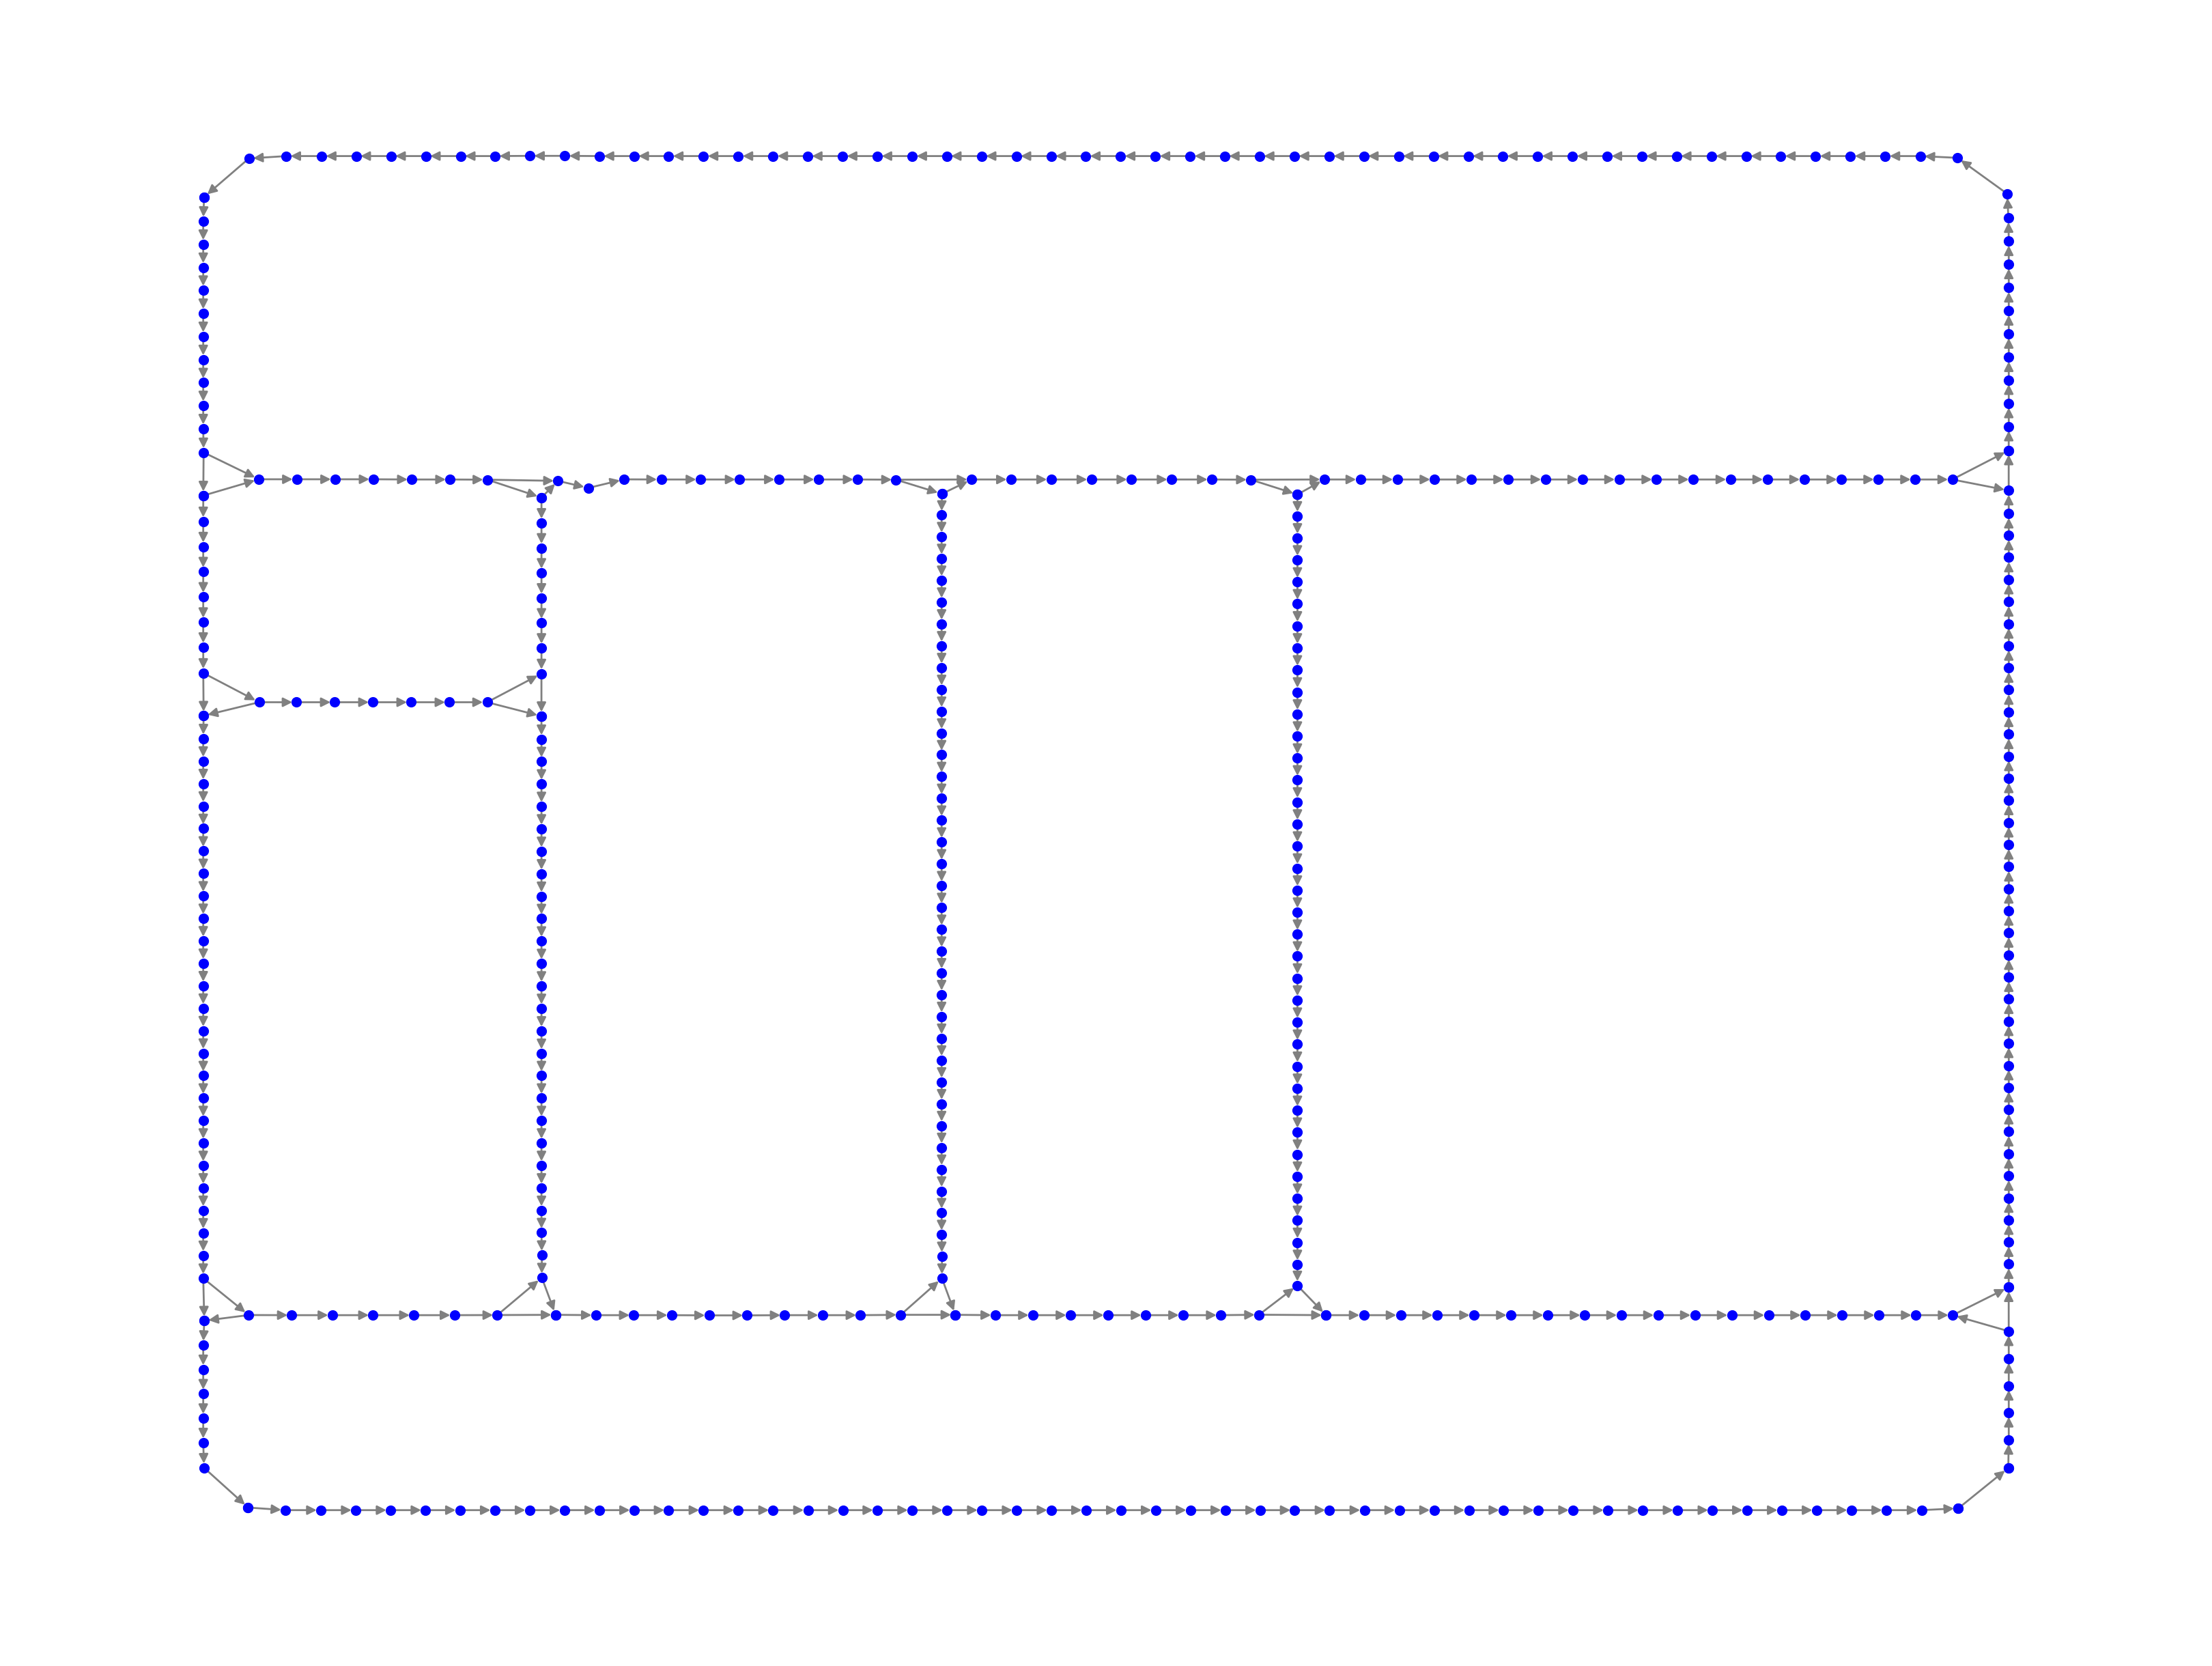

In [85]:
# --- Visualization ---
pos = {n: G_right.nodes[n]['pos'] for n in G_right.nodes}
nx.draw(G_right, pos=pos, node_size=20, node_color='blue', edge_color='gray')

In [76]:
import pickle 

with open("town01-vehicles-left-100.pkl", "wb") as f:
    pickle.dump(G_left, f)
    
with open("town01-vehicles-right-100.pkl", "wb") as f:
    pickle.dump(G_right, f)

with open("town01-vehicles-2lanes-100.pkl", "wb") as f:
    pickle.dump(G_combined, f)

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def plot_random_shortest_path(G, max_tries=1000, seed=None, directed=False):
    """
    Pick two random nodes that are connected by a path
    (across segments), find shortest path, and plot it.
    """
    if seed is not None:
        random.seed(seed)

    nodes = list(G.nodes())
    pos = nx.get_node_attributes(G, "pos")

    if len(nodes) < 2:
        print("⚠️ Not enough nodes.")
        return

    for _ in range(max_tries):
        start, goal = random.sample(nodes, 2)
        try:
            if directed:
                path = nx.shortest_path(G, start, goal)
            else:
                path = nx.shortest_path(G.to_undirected(), start, goal, weight="cost")
            if len(path) > 5:  # Only plot if path spans multiple segments
                print(f"🎯 Path found: {start} → {goal}, length={len(path)}")
                break
        except nx.NetworkXNoPath:
            continue
    else:
        print("❌ No sufficiently long path found.")
        return

    # --- Visualization ---
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_size=10, edge_color="lightgray", with_labels=False)

    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color="red", node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color="green", node_size=80)
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color="blue", node_size=80)

    plt.title(f"Shortest path from {start} → {goal} ({len(path)} nodes)")
    plt.axis("equal")
    plt.show()


In [25]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def plot_random_shortest_path_between_segments(G, seg_i, seg_j, lane_type="R", seed=None, directed=False):
    """
    Pick random start and goal nodes from two specified segments,
    find shortest path between them, and plot it.
    
    Parameters
    ----------
    G : networkx.Graph
        Road graph.
    seg_i, seg_j : tuple
        Segment IDs, e.g. (2, 3) and (4, 5)
    lane_type : str
        'R' or 'L' lane type.
    seed : int
        Random seed.
    directed : bool
        Whether to use directed paths.
    """
    if seed is not None:
        random.seed(seed)

    lane_label = lane_type.upper()
    pos = nx.get_node_attributes(G, "pos")

    # --- Filter nodes belonging to the two segments ---
    nodes_i = [n for n in G.nodes if n.startswith(f"{seg_i[0]}_{seg_i[1]}_{lane_label}")]
    nodes_j = [n for n in G.nodes if n.startswith(f"{seg_j[0]}_{seg_j[1]}_{lane_label}")]

    if not nodes_i or not nodes_j:
        print(f"⚠️ No nodes found for segments {seg_i} or {seg_j} ({lane_label})")
        return

    start = random.choice(nodes_i)
    goal = random.choice(nodes_j)

    try:
        if directed:
            path = nx.shortest_path(G, start, goal, weight="cost")
        else:
            path = nx.shortest_path(G.to_undirected(), start, goal, weight="cost")
        print(f"🎯 Path found: {start} → {goal}, length={len(path)}")
    except nx.NetworkXNoPath:
        print(f"❌ No path found between {seg_i} and {seg_j}")
        return

    # --- Visualization ---
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_size=10, edge_color="lightgray", with_labels=False)

    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color="red", node_size=30)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color="green", node_size=80)
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color="blue", node_size=80)

    plt.title(f"Shortest path from {seg_i} → {seg_j} ({len(path)} nodes, lane {lane_label})")
    plt.axis("equal")
    plt.show()


🎯 Path found: 0_2_R_0 → 14_15_R_44, length=98


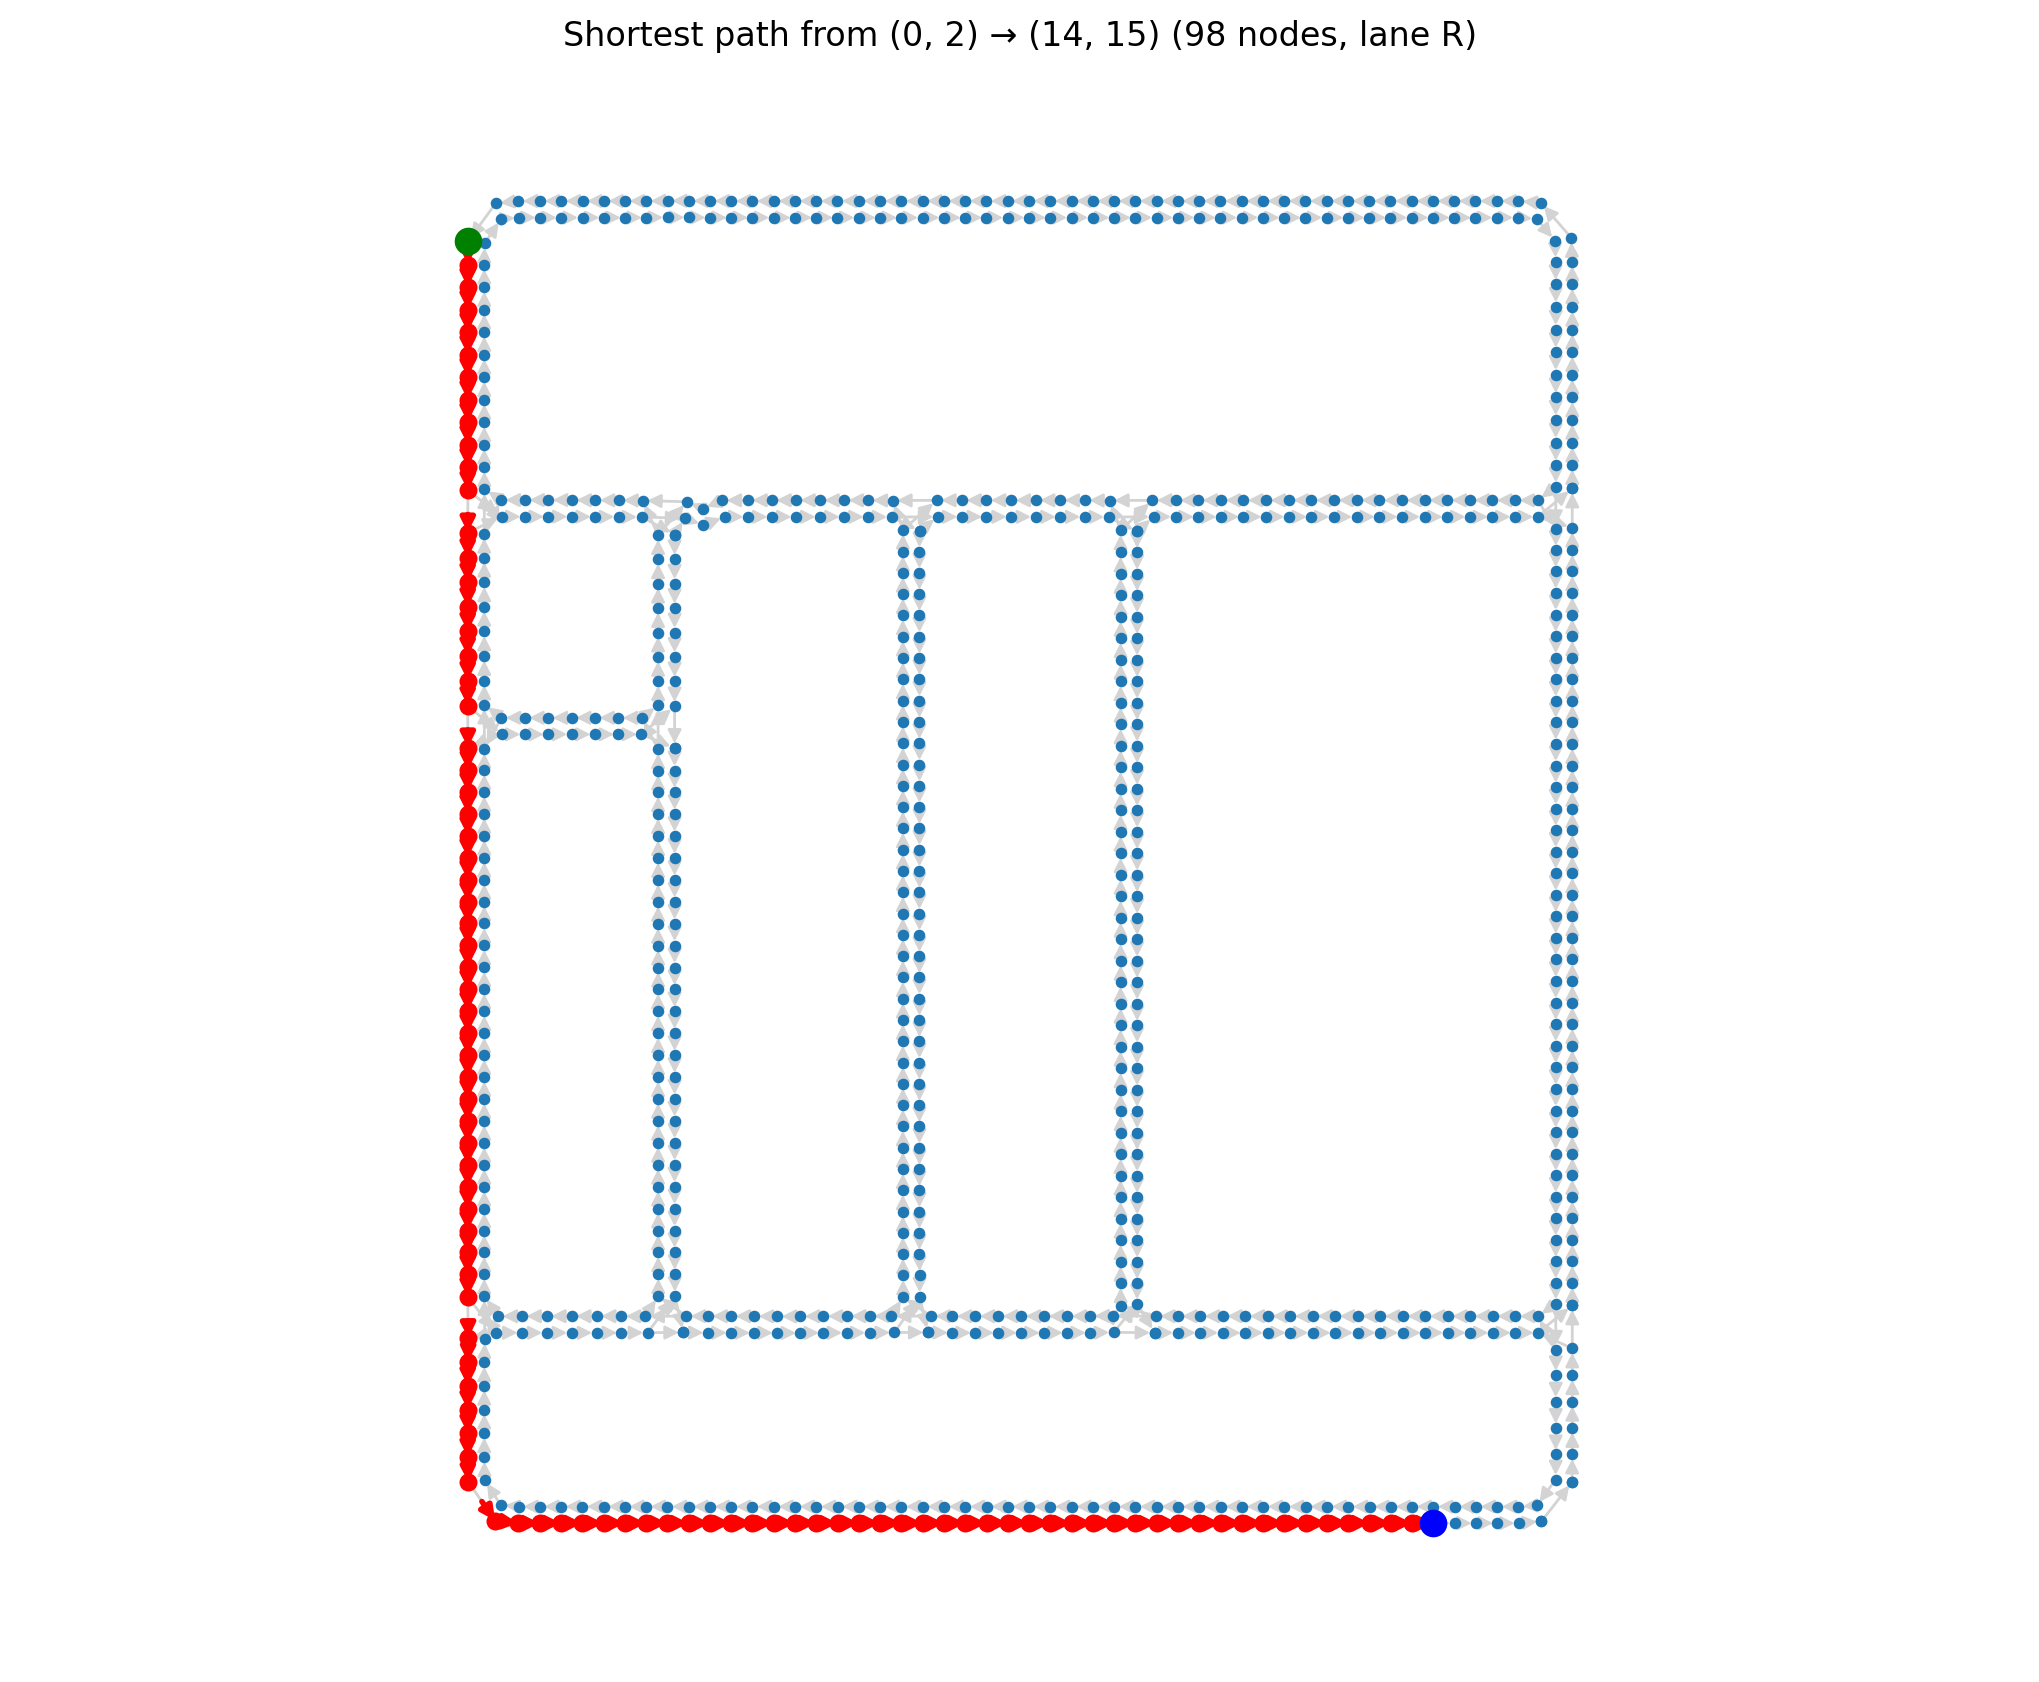

In [84]:
a, b = (0, 2), (14, 15)
plot_random_shortest_path_between_segments(G_combined, a, b, "R")

🎯 Path found: 1_6_R_2 → 8_10_R_0, length=48


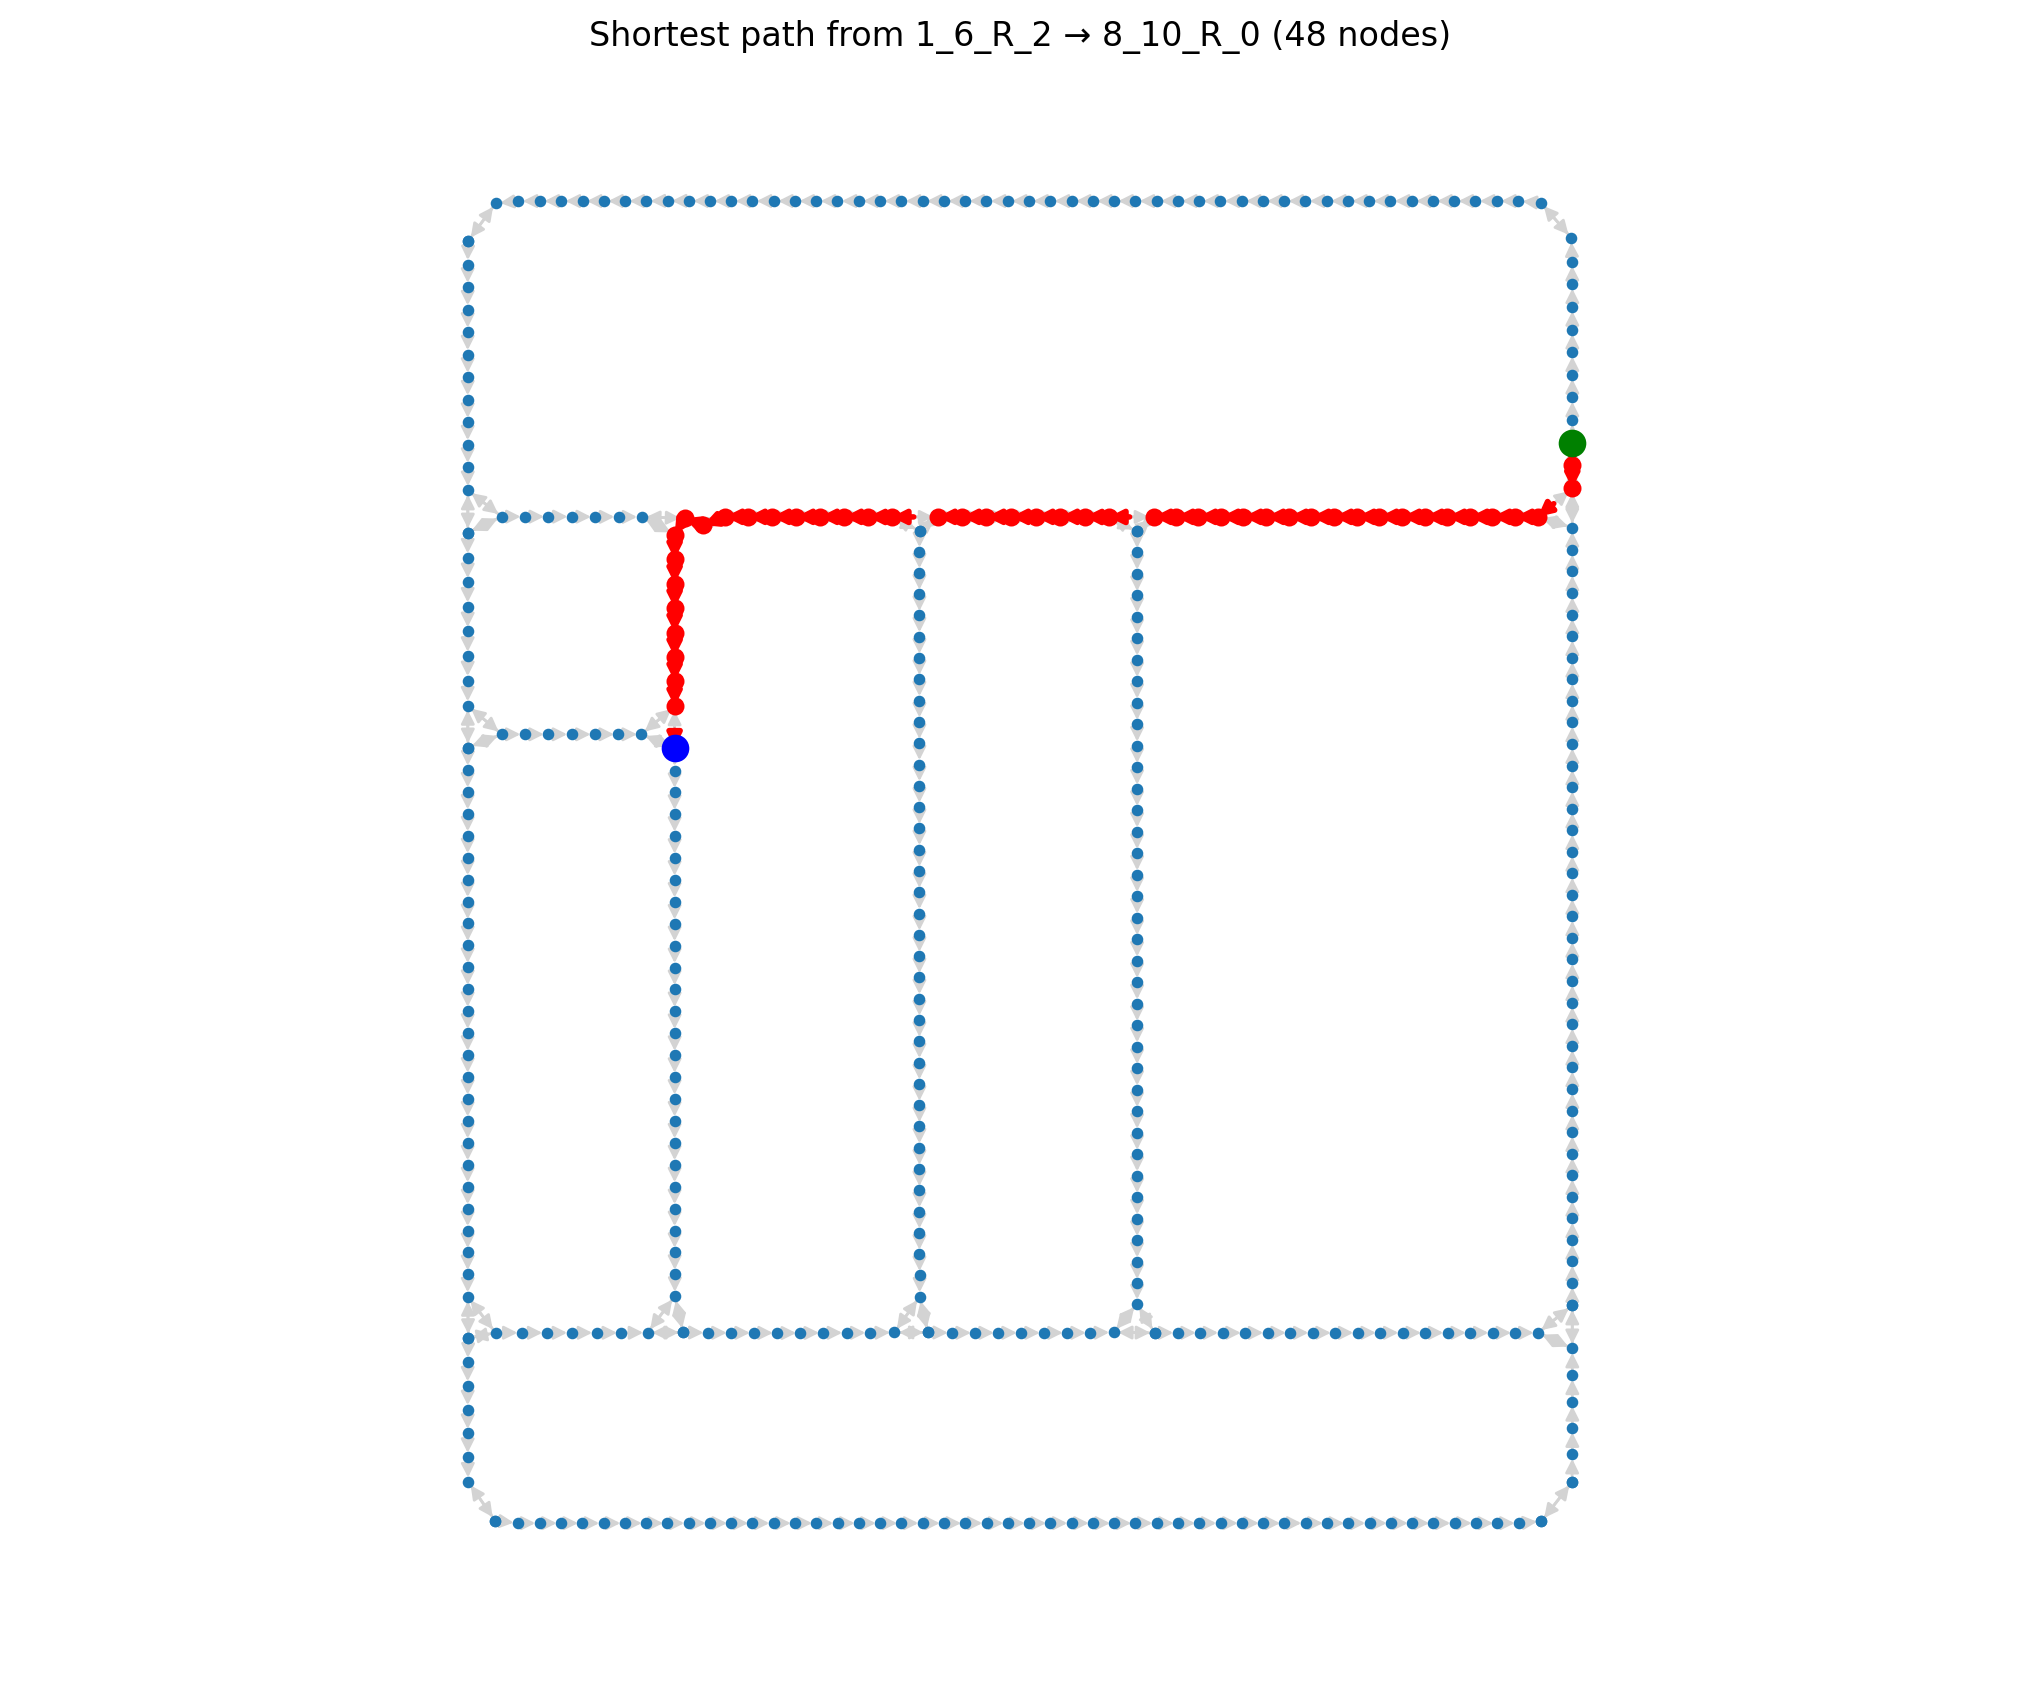

In [24]:
# Assuming G_combined is your full lane graph
plot_random_shortest_path(G_right, seed=1)
